Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images, please make sure to upload the dataset in "Cancer_Dataset" folder before running.
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Test")

In [4]:
data_dir_train.resolve()

PosixPath('/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training data count", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test data count", image_count_test)

Training data count 2239
Test data count 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir_train.resolve(),
    batch_size = batch_size,
    image_size = (img_width, img_height),
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123)
train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir_train.resolve(),
    batch_size = batch_size,
    image_size = (img_width, img_height),
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 123)
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

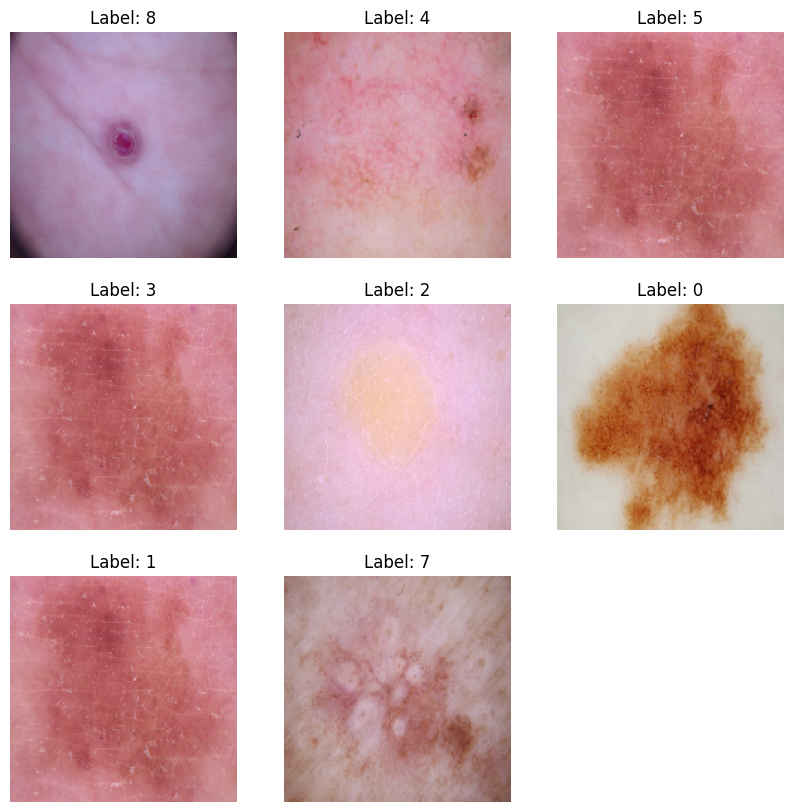

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to select one image from each label
def take_one_image_per_label(images, labels):
    unique_labels, indices = tf.unique(labels)

    # Select the first image from each label
    selected_images = tf.gather(images, indices[:tf.size(unique_labels)])
    return selected_images, unique_labels

# Apply the function to the dataset
selected_images_dataset = train_ds.map(take_one_image_per_label)

# Get a batch of images and labels from the selected dataset
for images, labels in selected_images_dataset.take(1):
    # Plot the selected images
    plt.figure(figsize=(10, 10))
    for i in range(len(labels)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

rescaled_input = keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(180, 180, 3))
model = Sequential()
model.add(rescaled_input)

# 1st convolution layer with 32 features
model.add(Conv2D(32, 3, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd convolution layer with 64 features
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd convolution layer with 128 features
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(9, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 20, 20, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 246s 2s/step - loss: 1.8760 - accuracy: 0.3722 - val_loss: 2.2115 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 103ms/step - loss: 1.5346 - accuracy: 0.4475 - val_loss: 2.3802 - val_accuracy: 0.1678
Epoch 3/20
56/56 [==============================] - 6s 103ms/step - loss: 1.4009 - accuracy: 0.5056 - val_loss: 2.4237 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 8s 139ms/step - loss: 1.4005 - accuracy: 0.4916 - val_loss: 2.4864 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 6s 109ms/step - loss: 1.2903 - accuracy: 0.5374 - val_loss: 2.6901 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 8s 137ms/step - loss: 1.1900 - accuracy: 0.5675 - val_loss: 2.6026 - val_accuracy: 0.2327
Epoch 7/20
56/56 [==============================] - 7s 126ms/step - loss: 1.1089 - accuracy: 0.6066 - val_loss: 2.2129 - val_accuracy: 0.2931
Epoch 8

### Visualizing training results

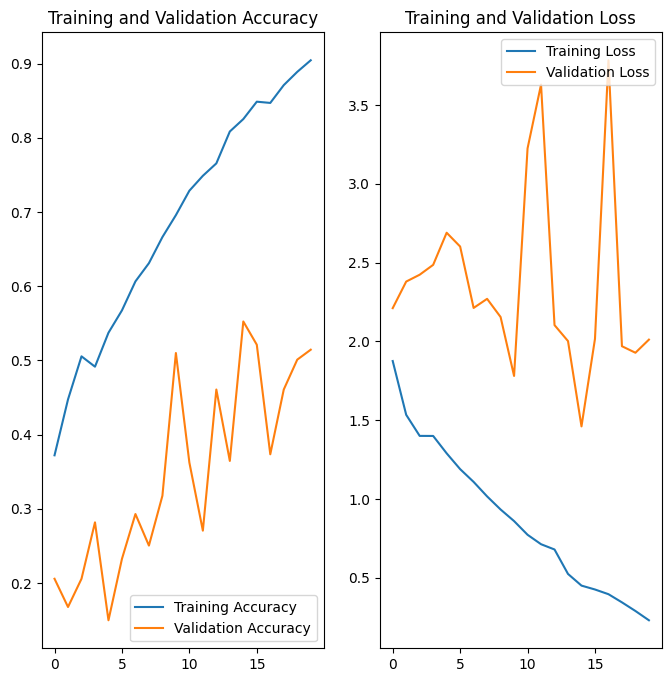

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1.   We can see that there is huge overfitting in the model as the difference between training accuracy and validation accuracy is very large.
2.   This might be due to the fact that we have not used dropout layers after convolution layers. Let do that and see the results.



### Todo:
### Create the model, compile and train the model


In [17]:
from keras.layers import BatchNormalization

rescaled_input = keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(180, 180, 3))
model = Sequential()
model.add(rescaled_input)

# 1st convolution layer with 32 features
model.add(Conv2D(32, 3, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolution layer with 64 features
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer with 128 features
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(9, activation='softmax'))

### Compiling the model

In [18]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 batch_normalization_3 (Bat  (None, 20, 20, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 32)       

### Training the model

In [19]:
# Train the model again for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 138ms/step - loss: 2.0070 - accuracy: 0.3337 - val_loss: 2.2116 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 8s 137ms/step - loss: 1.6427 - accuracy: 0.4174 - val_loss: 2.2554 - val_accuracy: 0.2595
Epoch 3/20
56/56 [==============================] - 6s 110ms/step - loss: 1.5520 - accuracy: 0.4420 - val_loss: 2.3348 - val_accuracy: 0.1991
Epoch 4/20
56/56 [==============================] - 8s 136ms/step - loss: 1.4907 - accuracy: 0.4738 - val_loss: 2.3090 - val_accuracy: 0.2282
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4124 - accuracy: 0.4961 - val_loss: 2.2901 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 8s 145ms/step - loss: 1.3335 - accuracy: 0.5128 - val_loss: 2.4564 - val_accuracy: 0.1700
Epoch 7/20
56/56 [==============================] - 6s 110ms/step - loss: 1.3155 - accuracy: 0.5246 - val_loss: 2.0137 - val_accuracy: 0.3356
Epoch

### Visualizing the results

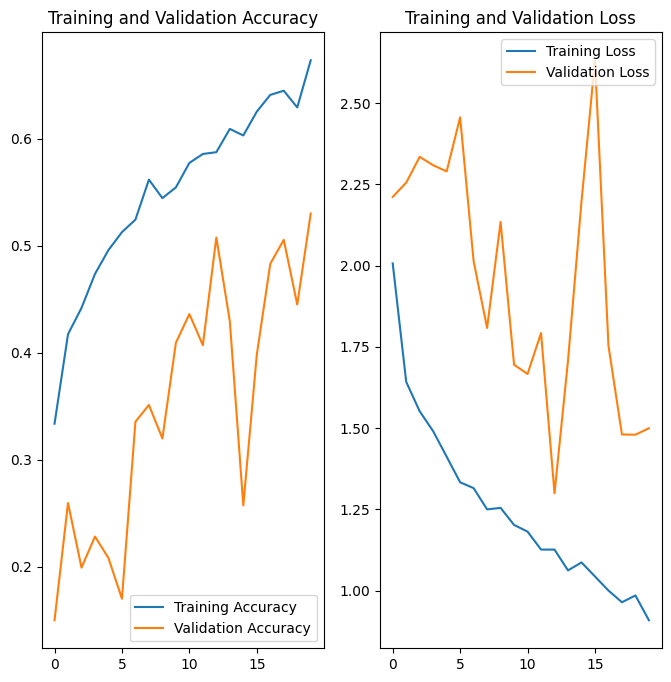

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. After adding dropout layers with 50% dropout, we have overcome model overfitting. We can reduced train vs validation accuracy to ~0.1 from 0.4.
2. However, now the model is underfitting as the overall accuracy has reduced. Lets create artificial images in the dataset by using the Augmentor package to increase model accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [21]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [22]:
import Augmentor

path_to_training_dataset = str(data_dir_train.resolve()) + '/'
path_to_training_dataset

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x781BE93BF940>: 100%|██████████| 500/500 [00:32<00:00, 15.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781BE8396620>: 100%|██████████| 500/500 [00:30<00:00, 16.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781BE82F2F80>: 100%|██████████| 500/500 [00:32<00:00, 15.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x781BE82F1C30>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x781BE83736D0>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781BE84BC3A0>: 100%|██████████| 500/500 [00:22<00:00, 21.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x781BE8370BE0>: 100%|██████████| 500/500 [00:46<00:00, 10.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x781BE91F44C0>: 100%|██████████| 500/500 [00:22<00:00, 22.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781BE82F07F0>: 100%|██████████| 500/500 [00:23<00:00, 21.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [23]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0032409.jpg_df0f0a60-52a1-4f63-a4d3-937ebc66e0ed.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0031197.jpg_672174be-4acc-491e-a820-fcf54426bdbd.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0033123.jpg_e6c6a5a9-3b6f-4024-a707-fe7a10cacc1b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0031719.jpg_6286bb46-adce-40b0-a07f-7153cbd53071.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_8248e492-b1a5-4621-9486-0033264fba48.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Cancer_Dataset/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_b9dc92dd-d661-4f1a-b154

In [25]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [27]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
dermatofibroma                500
actinic keratosis             500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
nevus                         500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [28]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [29]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  path_to_training_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_dataset,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [32]:
rescaled_input = keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(180, 180, 3))
model = Sequential()
model.add(rescaled_input)

# 1st convolution layer with 32 features
model.add(Conv2D(32, 3, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd convolution layer with 64 features
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer with 128 features
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [33]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 20, 20, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 32)       

#### **Todo:**  Train your model

In [34]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 71s 179ms/step - loss: 1.9353 - accuracy: 0.3084 - val_loss: 2.5843 - val_accuracy: 0.1826
Epoch 2/30
169/169 [==============================] - 20s 118ms/step - loss: 1.5335 - accuracy: 0.4128 - val_loss: 1.9958 - val_accuracy: 0.2331
Epoch 3/30
169/169 [==============================] - 21s 125ms/step - loss: 1.4233 - accuracy: 0.4497 - val_loss: 1.8648 - val_accuracy: 0.3549
Epoch 4/30
169/169 [==============================] - 20s 120ms/step - loss: 1.3083 - accuracy: 0.4968 - val_loss: 1.4781 - val_accuracy: 0.4499
Epoch 5/30
169/169 [==============================] - 21s 125ms/step - loss: 1.1923 - accuracy: 0.5365 - val_loss: 6.3003 - val_accuracy: 0.1381
Epoch 6/30
169/169 [==============================] - 21s 121ms/step - loss: 1.1503 - accuracy: 0.5640 - val_loss: 1.6292 - val_accuracy: 0.4217
Epoch 7/30
169/169 [==============================] - 20s 118ms/step - loss: 1.0708 - accuracy: 0.5953 - val_loss: 1.5459 - val_ac

#### **Todo:**  Visualize the model results

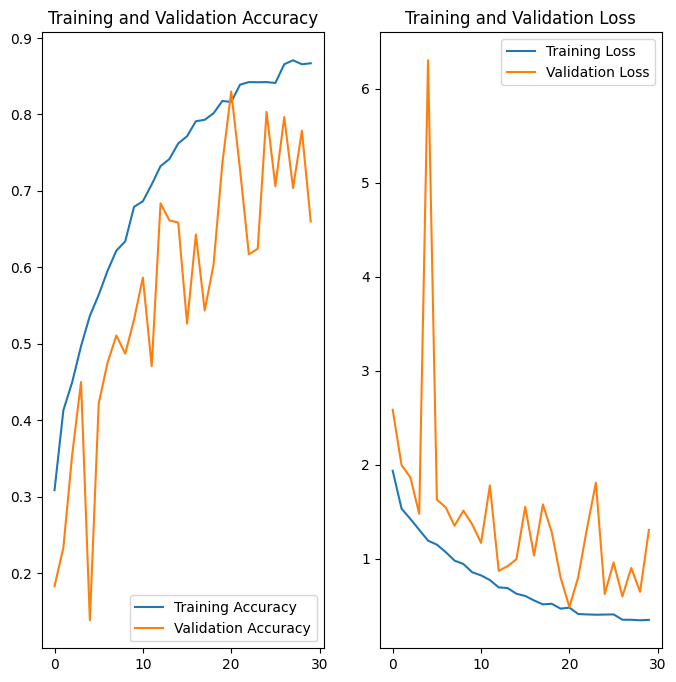

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. We did see that class handling class imbalance helped in striking a good balance between overfitting and underfitting.
2. We saw an increase in overall model accuracy after generating artificial images.